## Напишем класс датасета и передадим в даталоадеры

In [2]:
import torch
import torch.utils.data as data
import librosa
import numpy as np
import os
import torch.nn.utils.rnn as rnn_utils

class AudioDataset(data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for file in os.listdir(cls_dir):
                if file.endswith('.wav'):
                    self.samples.append((os.path.join(cls_dir, file), cls))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, cls = self.samples[idx]
        audio, sr = librosa.load(audio_path)
        
        # Нормализация аудио данных от 0 до 1
        audio = (audio - np.min(audio)) / (np.max(audio) - np.min(audio) + 1e-8)  # Добавляем малое значение для предотвращения деления на ноль
        
        if self.transform:
            audio = self.transform(audio, sr)
        # print(self.class_to_idx[cls])
        return audio, self.class_to_idx[cls]
  # Используем clone() для создания копии
  # Преобразуем аудио в тензор здесь

def stft_transform(audio, sr):
    # Ресэмплинг
    audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    # Дополнение до фиксированной длины
    audio = np.pad(audio, (0, 22050 - len(audio)), mode='constant')
    
    # Вычисление мел-спектрограммы
    melspec = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=512, hop_length=128)
    melspec = librosa.power_to_db(melspec).astype(np.float32)
    
    return torch.tensor(melspec)  # Возвращаем результат в виде тензора

def collate_fn(batch):
    audio, labels = zip(*batch)
    audio = torch.stack(audio)
    labels = torch.tensor(labels)
    return audio, labels

batch_size = 64

train_dataset = AudioDataset(root_dir='/kaggle/input/data-sppech-to-text/v0.01_train',transform = stft_transform)


# Создаем подмножества данных
train_size = int(0.2 * len(train_dataset))  # 80% для тренировки
val_size = int(0.02 * len(train_dataset))  # 10% для валидации
test_size = len(train_dataset) - train_size - val_size  # остальное для тестирования

# Создаем индексы для каждого подмножества
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(train_dataset)), [train_size, val_size, test_size]
)

# Создаем новые наборы данных из подмножеств
train_subset = data.Subset(train_dataset, train_indices)
val_subset = data.Subset(train_dataset, val_indices)
test_subset = data.Subset(train_dataset, test_indices)

# Создаем загрузчики данных
train_dataloader = data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last= True)
val_dataloader = data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last = True)
test_dataloader = data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last = True)


# # Инициализируем базу данныX_train, X_test, y_train, y_testх
# train_dataset = AudioDataset(root_dir='/kaggle/input/data-sppech-to-text/v0.01_train',transform = stft_transform)
# test_dataset = AudioDataset(root_dir='/kaggle/input/data-sppech-to-text/v0.01_test',transform = stft_transform)
# val_dataset = AudioDataset(root_dir='/kaggle/input/data-sppech-to-text/v0.01_validation',transform = stft_transform)


# # Создаем подмножество данных
# subset_size = 2000  # количество файлов, которое вы хотите использовать
# subset_indices = random.sample(range(len(train_dataset)), subset_size)

# # # Создаем новый набор данных из подмножества
# subset_dataset = data.Subset(train_dataset, subset_indices)

# train_dataloader = data.DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn)
# test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



### Визуализация семпла

[ 20 -30  15 ... 274 160 118]


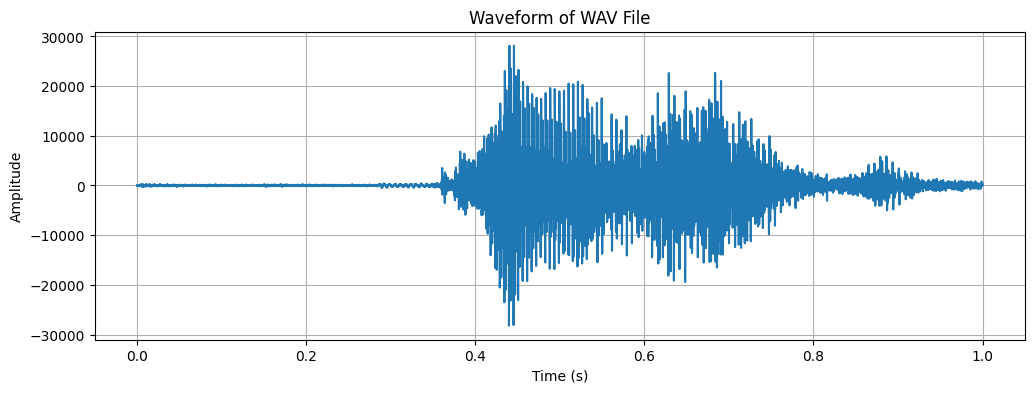

In [3]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# Укажите путь к вашему файлу
file_path = '/kaggle/input/data-sppech-to-text/v0.01_train/dog/00b01445_nohash_0.wav'

# Открываем WAV-файл
try:
    with wave.open(file_path, 'rb') as wave_file:
        # Получаем параметры файла
        num_channels = wave_file.getnchannels()
        frame_rate = wave_file.getframerate()
        num_frames = wave_file.getnframes()
        samp_width = wave_file.getsampwidth()

        # Читаем все фреймы из файла
        wave_data = wave_file.readframes(num_frames)
        
        # Преобразуем байты в numpy array
        audio_array = np.frombuffer(wave_data, dtype=np.int16)

        # Если стерео, разделяем каналы
        if num_channels == 2:
            audio_array = audio_array.reshape(-1, 2).T
            # Выбираем один канал, например, левый
            audio_array = audio_array[0]

        # Создаем временную ось
        time = np.linspace(0, num_frames / float(frame_rate), num=num_frames)

        # Выводим данные как временной ряд
        print(audio_array)

        # Визуализация (опционально)
        plt.figure(figsize=(12, 4))
        plt.plot(time, audio_array)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Waveform of WAV File')
        plt.grid(True)
        plt.show()

except wave.Error as e:
    print(f"Error opening WAV file: {e}")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


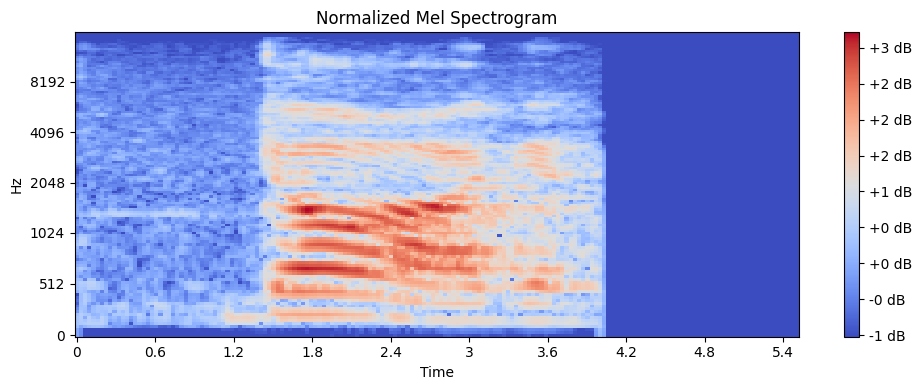

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torch

def melspec(audio_path):
    # Загрузка аудио файла
    audio, sr = librosa.load(audio_path)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    audio = np.pad(audio, (0, 22050 - len(audio)), mode='constant')  # Дополнение до фиксированной длины
    audio = torch.tensor(audio)   

    # Вычисление мел-спектрограммы
    melspec = librosa.feature.melspectrogram(y=audio.numpy(), sr=16000, n_fft=512, hop_length=128)
    melspec_db = librosa.power_to_db(melspec).astype(np.float32)

    # Нормализация
    mean = np.mean(melspec_db)
    std = np.std(melspec_db)
    melspec_normalized = (melspec_db - mean) / (std + 1e-6)  # Добавляем эпсилон для предотвращения деления на ноль

    # Визуализация нормализованной мел-спектрограммы
    plt.figure(figsize=(10, 4))
    img = librosa.display.specshow(melspec_normalized, x_axis='time', y_axis='mel', sr=16000, fmax=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Normalized Mel Spectrogram')
    plt.tight_layout()
    plt.show()

    return melspec_normalized

# Пример вызова функции
_ = melspec('/kaggle/input/data-sppech-to-text/v0.01_train/dog/00b01445_nohash_0.wav')


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torch

def melspec(audio_path):
    # Загрузка аудио файла
    audio, sr = librosa.load(audio_path)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    audio = np.pad(audio, (0, 22050 - len(audio)), mode='constant')  # Дополнение до фиксированной длины
    audio = torch.tensor(audio)   

    # Вычисление мел-спектрограммы
    melspec = librosa.feature.melspectrogram(y=audio.numpy(), sr=16000, n_fft=512, hop_length=128)
    melspec_db = librosa.power_to_db(melspec).astype(np.float32)

    # Визуализация мел-спектрограммы без нормализации
    plt.figure(figsize=(10, 4))
    img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', sr=16000, fmax=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram (Without Normalization)')
    plt.tight_layout()
    plt.show()

    return melspec_db

# Пример вызова функции
_ = melspec('/kaggle/input/data-sppech-to-text/v0.01_train/dog/00b01445_nohash_0.wav')


In [ ]:
a, b = next(iter(train_dataloader))
print(a.shape)
print(len(b))

In [ ]:
print(a[0][70,:])

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


## Напишем нейросеть со сверточными слоями

In [ ]:
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter  # Импортируем SummaryWriter

# Убедитесь, что start_time определен в начале
start_time = time.time()

class SpectrogramClassifier(nn.Module):
    def __init__(self):
        super(SpectrogramClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 14 * 19, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 30)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = nn.functional.relu(nn.functional.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.bn3(self.conv3(x)), 2))
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x

# Создание модели и оптимизатора
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramClassifier().to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
def train_loop(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
    train_loss_history = []
    val_accuracy_history = []
    
    # Инициализация TensorBoard
    writer = SummaryWriter()  # Создаем экземпляр SummaryWriter
    
    for epoch in range(num_epochs):
        epoch_loss = []
        model.train()  # Убедимся, что модель в режиме обучения
        
        for batch_idx, (spectrogram, label) in enumerate(train_dataloader):
            spectrogram = spectrogram.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = model(spectrogram)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            
            # Логируем лосс каждые 10 батчей
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')
                writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_dataloader) + batch_idx)  # Логируем потери

        # Сохраняем средний лосс за эпоху
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        train_loss_history.append(avg_loss)

        # Оценка модели на валидационном наборе
        model.eval()  # Переключаем модель в режим оценки
        correct = 0
        total = 0
        
        with torch.no_grad():
            for spectrogram, label in val_dataloader:
                spectrogram = spectrogram.to(device)
                label = label.to(device)
                output = model(spectrogram)
                _, predicted = torch.max(output, 1)
                correct += (predicted == label).sum().item()
                total += label.size(0)

        accuracy = correct / total
        val_accuracy_history.append(accuracy)

        # Логируем точность после каждой эпохи
        print(f'Epoch {epoch+1}, Val Accuracy: {accuracy:.4f}')
        writer.add_scalar('Accuracy/Validation', accuracy, epoch)  # Логируем точность

    writer.close()  # Закрываем SummaryWriter после завершения обучения
    return train_loss_history, val_accuracy_history

# Обучение модели
train_loss, val_accuracy = train_loop(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=3)

# Вывод результатов
end_time = time.time()
print(f"Время работы: {end_time - start_time:.2f} секунд")

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('График потерь')
plt.legend()
plt.grid()
plt.savefig('train_loss.png')  # Сохранение графика потерь в файл
plt.show()

# Построение графиков точности
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy, label='Val Accuracy', color='green')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('График точности')
plt.legend()
plt.grid()
plt.savefig('val_accuracy.png')  # Сохранение графика точности в файл
plt.show()


In [4]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.0 MB/s eta 0:00:0000:01


In [5]:

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [6]:
spike_grad = surrogate.atan(alpha = 1.0)
beta = 0.95
# batch_size = 256
num_steps = 10

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold = False,  threshold = 1.0, learn_beta = False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold = False, threshold = 1.0, learn_beta = False)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.lif3 = snn.Leaky(beta=beta,spike_grad = spike_grad, learn_threshold = False, threshold = 1.0, learn_beta = False)
        self.fc1 = nn.Linear(128*14*19, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold = False, threshold = 1.0, learn_beta = False)
        self.bn5 = nn.BatchNorm1d(30)
        self.fc2 = nn.Linear(128, 30)
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold = False, threshold = 1.0, learn_beta = False)
       
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()
        
        x = x.unsqueeze(1)       
        cur1 = nn.functional.max_pool2d(self.conv1(x),2)    
        cur1 = self.bn1(cur1)
        # cur1 = torch.relu(cur1)
        spk1, mem1 = self.lif1(cur1,mem1)       
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)        
        cur2 = self.bn2(cur2)
        # cur2 = torch.relu(cur2)
        spk2, mem2 = self.lif2(cur2,mem2)
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        # cur3 = torch.relu(cur3)
        spk3, mem3 = self.lif3(cur3,mem3)
        batch_size = spk3.shape[0]
        cur4 = self.fc1(spk3.view(batch_size, -1))
        cur4 = self.bn4(cur4)
        # cur4 = torch.relu(cur4)
        spk4, mem4 = self.lif4(cur4,mem4)
        cur5 = self.fc2(spk4)
        cur5 = self.bn5(cur5)
        spk5, mem5 = self.lif5(cur5,mem5)
        return spk5, mem5


In [ ]:
a, b= next(iter(train_dataloader))
a, b = a.to(device), b.to(device)

In [ ]:
net = Net().to(device)
# print("spikes = ",net.forward(a))
net.forward(a)



In [7]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)
      # utils.reset(net)
      
  
  return torch.stack(spk_rec), torch.stack(mem_rec)


In [8]:
def batch_accuracy(train_loader, net, num_steps):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()
    
        train_loader = iter(train_loader)
        for data, targets in train_loader:
          data = data.to(device)
          targets = targets.to(device)
          spk_rec, _ = forward_pass(net, num_steps, data)
            
          acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
          total += spk_rec.size(1)
    
        if total == 0:
            return 0
    return acc/total


In [ ]:
import time
import matplotlib.pyplot as plt
import torch
from scipy import stats
# Предполагается, что Net, train_dataloader, val_dataloader и другие необходимые компоненты уже определены.

net = Net().to(device)
start_time = time.time()

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))
num_epochs = 3
loss_hist = []
test_acc_hist = []
counter = 0
loss_fn = SF.mse_count_loss()

# Outer training loop
for epoch in range(num_epochs):
    # Training loop
    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # Initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        
        # Получаем градиенты и вычисляем статистику
        # gradients = torch.nn.utils.parameters_to_vector(net.parameters()).detach()
        # max_grad = gradients.max().item()
        # min_grad = gradients.min().item()
        # mean_grad = gradients.mean().item()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss_val.item()}')
        
        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

    # Test set evaluation
    with torch.no_grad():
        net.eval()
        
        # Test set forward pass
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Epoch {epoch+1}, Test Acc: {test_acc * 100:.2f}%\n")
        
        test_acc_hist.append(test_acc.item())

end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


## Сеть поменьше


In [ ]:
spike_grad = surrogate.atan()
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [ ]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



In [ ]:
a, b= next(iter(train_dataloader))
a, b = a.to(device), b.to(device)

In [ ]:
net = SimpleConvNet().to(device)
net.forward(a)



## Эксперименты с суррогатными градиентами

## Atan

In [40]:
spike_grad = surrogate.atan()
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [41]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



729375
Epoch 1, Batch 0, Loss: 3.50846791267395
Epoch 1, Batch 10, Loss: 3.272258758544922
Epoch 1, Batch 20, Loss: 3.2852253913879395
Epoch 1, Batch 30, Loss: 3.1856045722961426
Epoch 1, Batch 40, Loss: 3.1424436569213867
Epoch 1, Batch 50, Loss: 3.130906581878662
Epoch 1, Batch 60, Loss: 3.1287307739257812
Epoch 1, Batch 70, Loss: 3.046849489212036
Iteration 0, Test Acc: 15.18%

Epoch 2, Batch 0, Loss: 2.8877806663513184
Epoch 2, Batch 10, Loss: 2.9242265224456787
Epoch 2, Batch 20, Loss: 2.8151538372039795
Epoch 2, Batch 30, Loss: 2.8278117179870605
Epoch 2, Batch 40, Loss: 2.780318021774292
Epoch 2, Batch 50, Loss: 2.711653470993042
Epoch 2, Batch 60, Loss: 2.7323412895202637
Epoch 2, Batch 70, Loss: 2.7348954677581787
Iteration 0, Test Acc: 34.60%

Время работы: 271.6862995624542 секунд


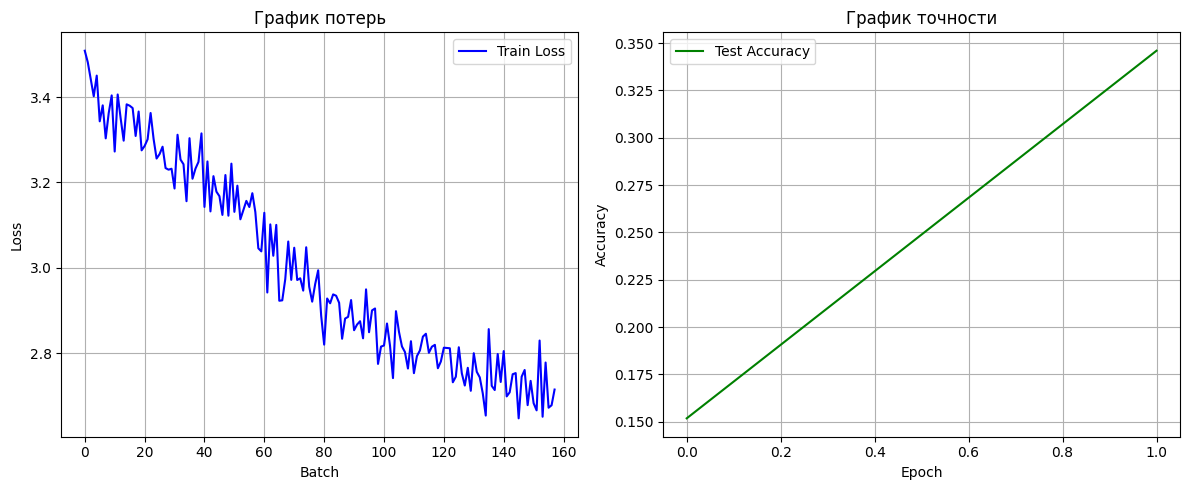

In [42]:
import time
net = SimpleConvNet().to(device)

start_time = time.time()

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 2
loss_hist_atan = []
test_acc_hist_atan = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist_atan.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist_atan.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist_atan, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist_atan, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


## Fast_sigmoid

In [43]:
spike_grad = surrogate.fast_sigmoid()
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [44]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



729375
Epoch 1, Batch 0, Loss: 3.437509298324585
Epoch 1, Batch 10, Loss: 3.4280662536621094
Epoch 1, Batch 20, Loss: 3.388962984085083
Epoch 1, Batch 30, Loss: 3.3684475421905518
Epoch 1, Batch 40, Loss: 3.428905963897705
Epoch 1, Batch 50, Loss: 3.3318090438842773
Epoch 1, Batch 60, Loss: 3.3787336349487305
Epoch 1, Batch 70, Loss: 3.3875362873077393
Iteration 0, Test Acc: 6.92%

Epoch 2, Batch 0, Loss: 3.3931047916412354
Epoch 2, Batch 10, Loss: 3.3795509338378906
Epoch 2, Batch 20, Loss: 3.323613405227661
Epoch 2, Batch 30, Loss: 3.3869895935058594
Epoch 2, Batch 40, Loss: 3.2990128993988037
Epoch 2, Batch 50, Loss: 3.3691563606262207
Epoch 2, Batch 60, Loss: 3.3400535583496094
Epoch 2, Batch 70, Loss: 3.3134396076202393
Iteration 0, Test Acc: 10.49%

Время работы: 238.93248319625854 секунд


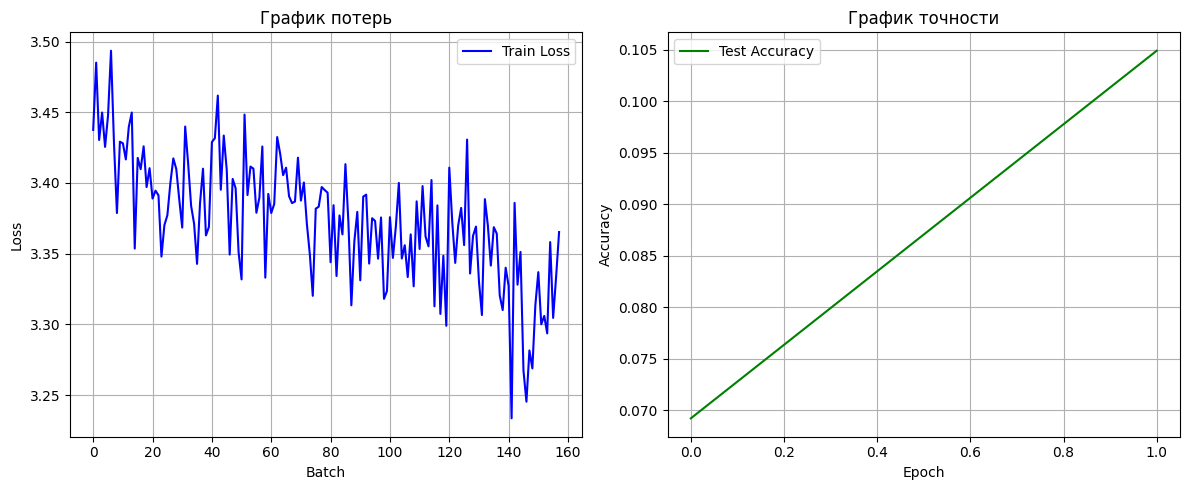

In [45]:
import time

start_time = time.time()
net = SimpleConvNet().to(device)

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 2
loss_hist_fs = []
test_acc_hist_fs = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist_fs.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist_fs.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist_fs, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist_fs, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


## Heaviside ( doesn't work )


In [46]:
spike_grad = surrogate.heaviside()
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [ ]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



In [ ]:
import time

start_time = time.time()
net = SimpleConvNet().to(device)

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 2
loss_hist = []
test_acc_hist = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


## Sigmoid

In [47]:
spike_grad = surrogate.sigmoid()
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [48]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



729375
Epoch 1, Batch 0, Loss: 3.4834022521972656
Epoch 1, Batch 10, Loss: 3.4011993408203125
Epoch 1, Batch 20, Loss: 3.4011993408203125
Epoch 1, Batch 30, Loss: 3.4011993408203125
Epoch 1, Batch 40, Loss: 3.4011993408203125
Epoch 1, Batch 50, Loss: 3.4011993408203125
Epoch 1, Batch 60, Loss: 3.4011993408203125
Epoch 1, Batch 70, Loss: 3.4011993408203125
Iteration 0, Test Acc: 2.90%

Время работы: 121.66451573371887 секунд


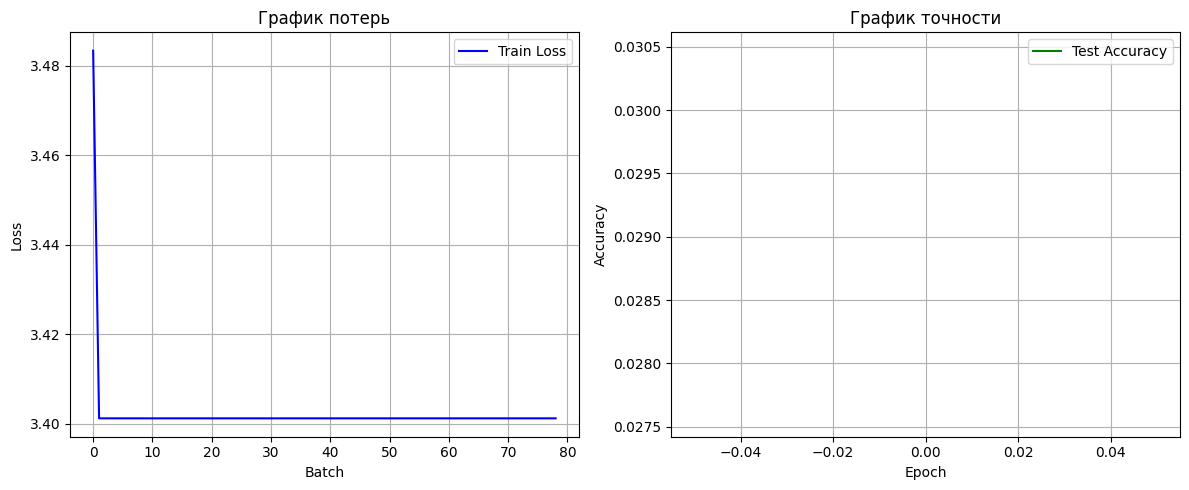

In [49]:
import time

start_time = time.time()
net = SimpleConvNet().to(device)

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 1
loss_hist_sigma = []
test_acc_hist_sigma = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist_sigma.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist_sigma.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist_sigma, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist_sigma, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


## spike_rate_escape

In [50]:
spike_grad = surrogate.spike_rate_escape()
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [51]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



729375
Epoch 1, Batch 0, Loss: 3.480194330215454
Epoch 1, Batch 10, Loss: 3.3480939865112305
Epoch 1, Batch 20, Loss: 3.3454372882843018
Epoch 1, Batch 30, Loss: 3.3931350708007812
Epoch 1, Batch 40, Loss: 3.2910959720611572
Epoch 1, Batch 50, Loss: 3.0999224185943604
Epoch 1, Batch 60, Loss: 3.097278594970703
Epoch 1, Batch 70, Loss: 3.0915184020996094
Iteration 0, Test Acc: 6.03%

Epoch 2, Batch 0, Loss: 3.0581822395324707
Epoch 2, Batch 10, Loss: 2.9422404766082764
Epoch 2, Batch 20, Loss: 3.0576977729797363
Epoch 2, Batch 30, Loss: 3.012180805206299
Epoch 2, Batch 40, Loss: 2.953887939453125
Epoch 2, Batch 50, Loss: 2.9766478538513184
Epoch 2, Batch 60, Loss: 2.9399802684783936
Epoch 2, Batch 70, Loss: 2.8671250343322754
Iteration 0, Test Acc: 14.73%

Время работы: 241.4560444355011 секунд


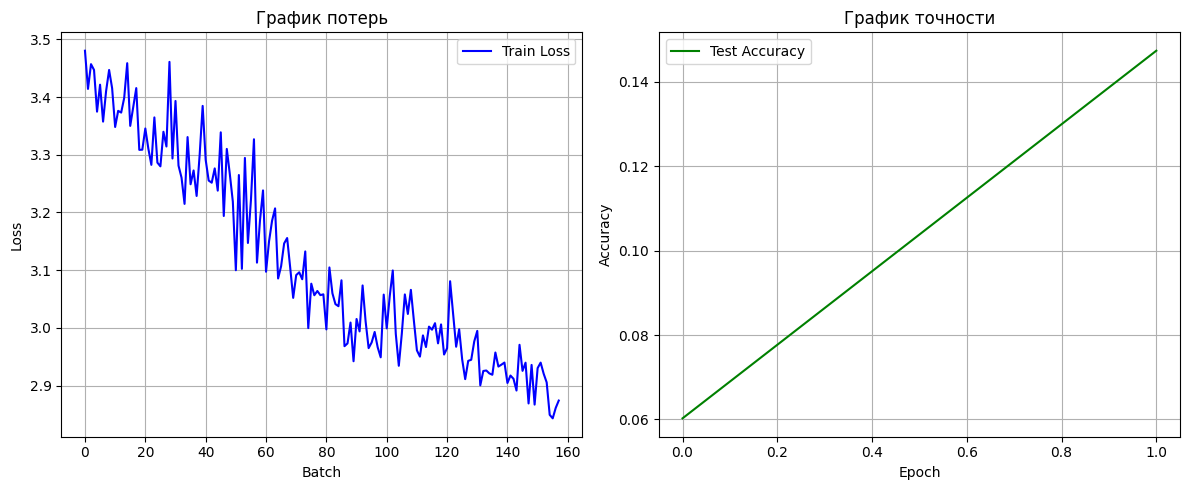

In [52]:
import time

start_time = time.time()
net = SimpleConvNet().to(device)

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 2
loss_hist_sre = []
test_acc_hist_sre = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist_sre.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist_sre.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist_sre, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist_sre, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


## straight_through_estimator

In [53]:
spike_grad = surrogate.straight_through_estimator()
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [54]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



729375
Epoch 1, Batch 0, Loss: 3.4890758991241455
Epoch 1, Batch 10, Loss: 3.376659870147705
Epoch 1, Batch 20, Loss: 3.268707275390625
Epoch 1, Batch 30, Loss: 3.1760432720184326
Epoch 1, Batch 40, Loss: 3.308311939239502
Epoch 1, Batch 50, Loss: 2.9527478218078613
Epoch 1, Batch 60, Loss: 2.972520589828491
Epoch 1, Batch 70, Loss: 2.9684743881225586
Iteration 0, Test Acc: 14.73%

Epoch 2, Batch 0, Loss: 3.027484655380249
Epoch 2, Batch 10, Loss: 2.9419219493865967
Epoch 2, Batch 20, Loss: 3.0145444869995117
Epoch 2, Batch 30, Loss: 2.9764251708984375
Epoch 2, Batch 40, Loss: 2.960017204284668
Epoch 2, Batch 50, Loss: 3.019562244415283
Epoch 2, Batch 60, Loss: 3.034313917160034
Epoch 2, Batch 70, Loss: 3.047945976257324
Iteration 0, Test Acc: 14.73%

Время работы: 239.35898113250732 секунд


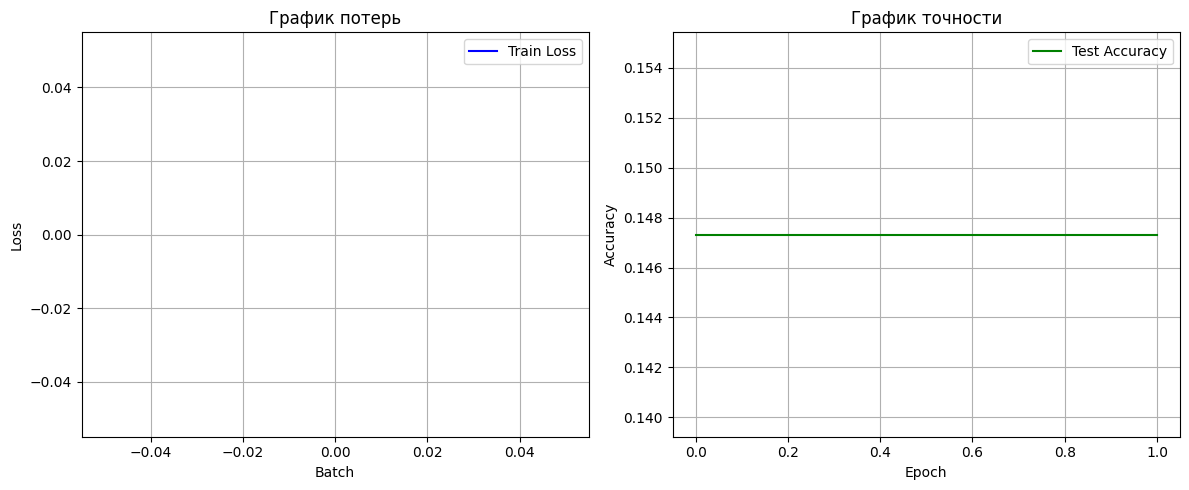

In [55]:
import time

start_time = time.time()
net = SimpleConvNet().to(device)

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 2
loss_hist_ste = []
test_acc_hist_ste = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc_ste = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist_ste.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist_ste, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist_ste, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


## triangular

In [56]:
spike_grad = surrogate.triangular()
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [57]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



729375
Epoch 1, Batch 0, Loss: 3.4996304512023926
Epoch 1, Batch 10, Loss: 3.4638633728027344
Epoch 1, Batch 20, Loss: 3.422166109085083
Epoch 1, Batch 30, Loss: 3.380202293395996
Epoch 1, Batch 40, Loss: 3.4066059589385986
Epoch 1, Batch 50, Loss: 3.366053581237793
Epoch 1, Batch 60, Loss: 3.394476890563965
Epoch 1, Batch 70, Loss: 3.373271942138672
Iteration 0, Test Acc: 14.73%

Epoch 2, Batch 0, Loss: 3.42386794090271
Epoch 2, Batch 10, Loss: 3.3891944885253906
Epoch 2, Batch 20, Loss: 3.5172996520996094
Epoch 2, Batch 30, Loss: 3.369112968444824
Epoch 2, Batch 40, Loss: 3.4171831607818604
Epoch 2, Batch 50, Loss: 3.4666175842285156
Epoch 2, Batch 60, Loss: 3.3903236389160156
Epoch 2, Batch 70, Loss: 3.4162025451660156
Iteration 0, Test Acc: 14.73%

Время работы: 245.08581399917603 секунд


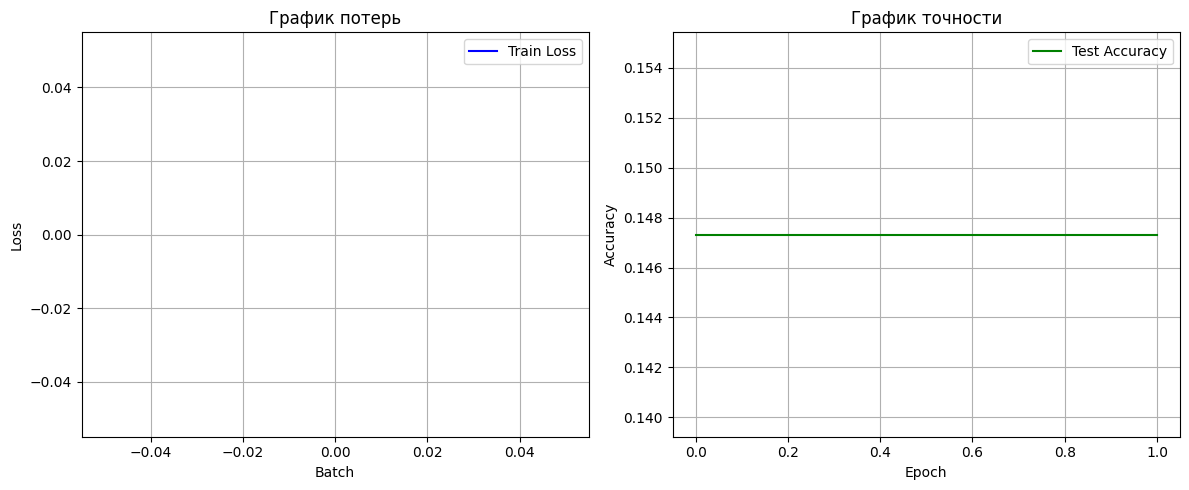

In [58]:
import time
net = SimpleConvNet().to(device)

start_time = time.time()

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 2
loss_hist_trian = []
test_acc_hist_trian = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc_trian = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist_trian.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist_trian, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist_trian, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


# Вывод всех исследуемых суррогатных градиентов

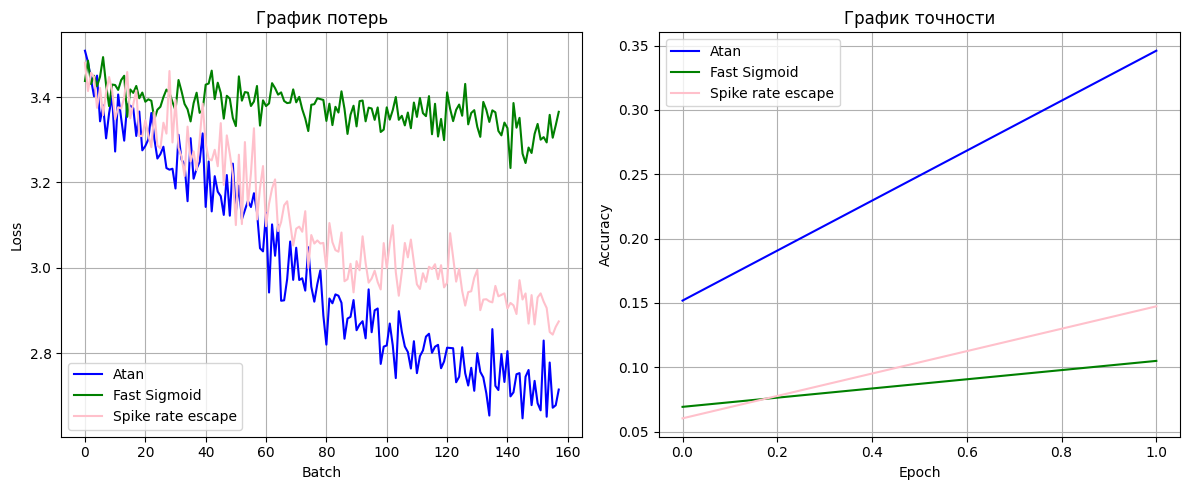

In [63]:
# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist_atan, label='Atan', color='blue')
plt.plot(loss_hist_fs, label='Fast Sigmoid', color='green')
plt.plot(loss_hist_sre, label='Spike rate escape', color='pink')

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist_atan, label='Atan', color='blue')
plt.plot(test_acc_hist_fs, label='Fast Sigmoid', color='green')
plt.plot(test_acc_hist_sre, label='Spike rate escape', color='pink')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()

## Эксперименты с ATan

In [ ]:
spike_grad = surrogate.atan(alpha = 5.0)
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [ ]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



In [ ]:
import time
net = SimpleConvNet().to(device)

start_time = time.time()

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 2
loss_hist = []
test_acc_hist = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


In [ ]:
spike_grad = surrogate.atan(alpha = 1.0)
# .SSO, 
beta = 0.98
# batch_size = 256

num_steps =15

In [ ]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad = spike_grad, learn_threshold=True, threshold=1.0, learn_beta=False)

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad = spike_grad,learn_threshold=True, threshold=1.0, learn_beta=False)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2), 2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)

        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        spk5, mem5 = self.lif5(cur5, mem5)
        
        
        
        return spk5, mem5



In [ ]:
import time
net = SimpleConvNet().to(device)

start_time = time.time()

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.9))
num_epochs = 2
loss_hist = []
test_acc_hist = []
counter = 0
loss_fn = SF.ce_rate_loss()

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)
     
        
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx }, Loss: {loss_val.item()}')
        loss_hist.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist.append(test_acc.item())

        # counter += 1
end_time = time.time()
print(f"Время работы: {end_time - start_time} секунд")

# Построение графиков потерь и точности после завершения обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist, label='Train Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('График потерь')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


## Повысил трешхолд для спайков ( понижение не дало положительного результата ) Повышение - тоже не дало прибавки

## Финальный запуск спайковой сети с экспериментально выявленными параметрами

In [9]:
spike_grad = surrogate.atan(alpha = 1.0)
# spike_grad = snn.surrogate.fast_sigmoid(slope=25) # surrogate.atan()
# .SSO, 
beta = 0.95
# batch_size = 256
num_steps = 5

In [10]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self, dropout_rate=0.2):  # Добавляем параметр dropout_rate
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_threshold=True,   threshold=2.0, learn_beta=True)
        self.dropout1 = nn.Dropout(dropout_rate)  # Дропаут после первого слоя

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_threshold=True, threshold=2.0, learn_beta=True)
        self.dropout2 = nn.Dropout(dropout_rate)  # Дропаут после второго слоя

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_threshold=True, threshold=2.0, learn_beta=True)
        self.dropout3 = nn.Dropout(dropout_rate)  # Дропаут после третьего слоя

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_threshold=True, threshold=2.0, learn_beta=True)
        self.dropout4 = nn.Dropout(dropout_rate)  # Дропаут после четвертого слоя

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.lif5 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_threshold=True, threshold=2.0, learn_beta=True)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        # print(mem1)
        x = x.unsqueeze(1)  

        
        cur1 = nn.functional.max_pool2d(self.conv1(x), 2)
        cur1 = self.bn1(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)
        spk1 = self.dropout1(spk1) 

        # Применяем второй сверточный слой и активацию с подвыборкой
        cur2 = nn.functional.max_pool2d(self.conv2(spk1), 2)
        cur2 = self.bn2(cur2)
        spk2, mem2 = self.lif2(cur2, mem2)
        spk2 = self.dropout2(spk2) 

        # Применяем третий сверточный слой и активацию с подвыборкой
        cur3 = nn.functional.max_pool2d(self.conv3(spk2),  2)
        cur3 = self.bn3(cur3)
        spk3, mem3 = self.lif3(cur3, mem3)
        spk3 = self.dropout3(spk3)  

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        cur4 = nn.functional.max_pool2d(self.conv4(spk3), 2)
        cur4 = self.bn4(cur4)
        spk4, mem4 = self.lif4(cur4, mem4)
        spk4 = self.dropout4(spk4)  
        batch_size = spk4.shape[0]

        # Плоское преобразование для полносвязного слоя
        cur_fc_input = spk4.view(batch_size, -1)  
        # Применяем полносвязный слой
        cur5  = self.fc(cur_fc_input)
        cur5 = self.bn_fc(cur5)
        
        spk5, mem5 = self.lif5(cur5, mem5)

        return spk5, mem5


In [ ]:
import time
import torch
import matplotlib.pyplot as plt

# Инициализация модели и устройства
net = SimpleConvNet().to(device)

start_time = time.time()

# Вывод количества параметров
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

# Оптимизатор и параметры обучения
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999))
num_epochs = 20
loss_hist = []
test_acc_hist = []

loss_fn = SF.mse_count_loss()

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Инициализация переменной для накопления потерь
    num_batches = 0   # Счетчик батчей

    for batch_idx, (data, targets) in enumerate(iter(train_dataloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Накопление потерь за эпоху
        epoch_loss += loss_val.item()
        num_batches += 1

    # Сохранение средней потери за эпоху
    avg_loss = epoch_loss / num_batches
    loss_hist.append(avg_loss)

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(val_dataloader, net, num_steps)
        print(f"Epoch {epoch + 1}, Test Acc: {test_acc * 100:.2f}%, Loss: {avg_loss:.4f}\n")
        
        # Сохраняем точность
        test_acc_hist.append(test_acc.item())

end_time = time.time()
print(f"Время работы: {end_time - start_time:.2f} секунд")

# Построение графиков
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_hist, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_acc_hist, label='Test Accuracy', marker='o')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()


729380
Epoch 1, Test Acc: 42.40%, Loss: 0.1631

Epoch 2, Test Acc: 63.12%, Loss: 0.0948

Epoch 3, Test Acc: 65.94%, Loss: 0.0644

Epoch 4, Test Acc: 73.12%, Loss: 0.0504

Epoch 5, Test Acc: 76.88%, Loss: 0.0421

Epoch 6, Test Acc: 75.94%, Loss: 0.0377

Epoch 7, Test Acc: 75.83%, Loss: 0.0337

Epoch 8, Test Acc: 79.48%, Loss: 0.0299

Epoch 9, Test Acc: 79.48%, Loss: 0.0270

Epoch 10, Test Acc: 76.56%, Loss: 0.0251

Epoch 11, Test Acc: 77.08%, Loss: 0.0224

Epoch 12, Test Acc: 78.02%, Loss: 0.0208

Epoch 13, Test Acc: 81.56%, Loss: 0.0197

Epoch 14, Test Acc: 80.10%, Loss: 0.0177

Epoch 15, Test Acc: 80.83%, Loss: 0.0164

Epoch 16, Test Acc: 81.98%, Loss: 0.0154

Epoch 17, Test Acc: 83.65%, Loss: 0.0152

Epoch 18, Test Acc: 81.88%, Loss: 0.0136

Epoch 19, Test Acc: 80.62%, Loss: 0.0134



## Искусственная такая же ( тут запускать )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleConvNet(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(SimpleConvNet, self).__init__()
        # Первый сверточный слой с ядром 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)  
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.dropout1 = nn.Dropout(dropout_rate)  # Дропаут после первого слоя

        # Второй сверточный слой с ядром 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        self.dropout2 = nn.Dropout(dropout_rate)  # Дропаут после второго слоя

        # Третий сверточный слой с ядром 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        self.dropout3 = nn.Dropout(dropout_rate)  # Дропаут после третьего слоя

        # Четвертый сверточный слой с ядром 3x3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # Нормализация
        self.dropout4 = nn.Dropout(dropout_rate)  # Дропаут после четвертого слоя

        # Полносвязный слой
        self.fc = nn.Linear(10240, 30)  # Выход размером 30 классов (необходимо пересчитать размер)
        self.bn_fc = nn.BatchNorm1d(30)  # Нормализация для полносвязного слоя
        self.dropout_fc = nn.Dropout(dropout_rate)  # Дропаут для полносвязного слоя

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавляем размерность для свертки (batch_size, channels, height, width)

        # Применяем первый сверточный слой и активацию с подвыборкой
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)  # Применяем дропаут
        x = nn.functional.max_pool2d(x, kernel_size=2)  # Подвыборка
        
        # Применяем второй сверточный слой и активацию с подвыборкой
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)  # Применяем дропаут
        x = nn.functional.max_pool2d(x, kernel_size=2)  # Подвыборка

        # Применяем третий сверточный слой и активацию с подвыборкой
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)  # Применяем дропаут
        x = nn.functional.max_pool2d(x, kernel_size=2)  # Подвыборка

        # Применяем четвертый сверточный слой и активацию с подвыборкой
        x = nn.functional.relu(self.bn4(self.conv4(x)))
        x = self.dropout4(x)  # Применяем дропаут
        x = nn.functional.max_pool2d(x, kernel_size=2)  # Подвыборка

        batch_size = x.shape[0]

        # Плоское преобразование для полносвязного слоя
        x = x.view(batch_size, -1)  # Изменяем размерность для полносвязного слоя
        
        # Применяем полносвязный слой и дропаут
        x = self.fc(x)
        x = self.bn_fc(x)
        x = self.dropout_fc(x)  # Применяем дропаут

        return x


Epoch 1, Batch 130, Loss: 1.8507
Epoch 1, Batch 140, Loss: 2.1147
Epoch 1, Batch 150, Loss: 1.8535
Epoch 1, Val Accuracy: 0.1844
Epoch 2, Batch 0, Loss: 2.0483
Epoch 2, Batch 10, Loss: 1.8277
Epoch 2, Batch 20, Loss: 1.9744
Epoch 2, Batch 30, Loss: 1.7214
Epoch 2, Batch 40, Loss: 1.4717
Epoch 2, Batch 50, Loss: 1.2221
Epoch 2, Batch 60, Loss: 1.6411
Epoch 2, Batch 70, Loss: 1.3073
Epoch 2, Batch 80, Loss: 1.5904
Epoch 2, Batch 90, Loss: 1.4710
Epoch 2, Batch 100, Loss: 1.6268
Epoch 2, Batch 110, Loss: 1.4559
Epoch 2, Batch 120, Loss: 1.6869
Epoch 2, Batch 130, Loss: 1.5228
Epoch 2, Batch 140, Loss: 1.2423
Epoch 2, Batch 150, Loss: 1.5054
Epoch 2, Val Accuracy: 0.5656
Epoch 3, Batch 0, Loss: 1.0395
Epoch 3, Batch 10, Loss: 1.3900
Epoch 3, Batch 20, Loss: 1.4653
Epoch 3, Batch 30, Loss: 1.2202
Epoch 3, Batch 40, Loss: 1.1211
Epoch 3, Batch 50, Loss: 1.3657
Epoch 3, Batch 60, Loss: 0.7923
Epoch 3, Batch 70, Loss: 1.0592
Epoch 3, Batch 80, Loss: 1.5473
Epoch 3, Batch 90, Loss: 1.4227
Epoch

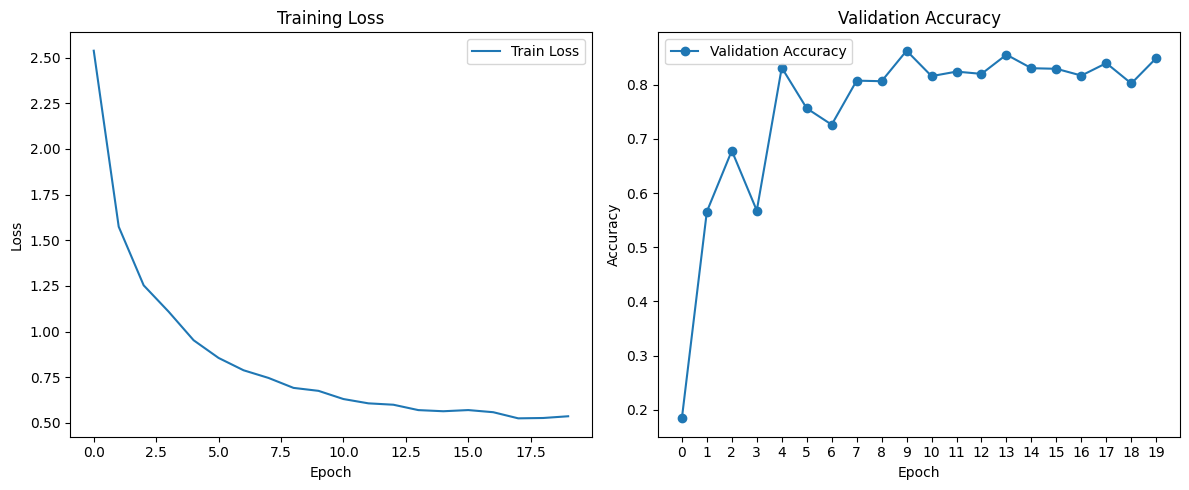

In [13]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Устройство и модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleConvNet().to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
start_time = time.time()

# Обучение модели
def train_loop(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
    train_loss_history = []
    val_accuracy_history = []
    
    for epoch in range(num_epochs):
        epoch_loss = []
        model.train()  # Убедимся, что модель в режиме обучения
        
        for batch_idx, (spectrogram, label) in enumerate(train_dataloader):
            spectrogram = spectrogram.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = model(spectrogram)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            
            # Логируем лосс каждые 10 батчей
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        # Сохраняем средний лосс за эпоху
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        train_loss_history.append(avg_loss)

        # Оценка модели на валидационном наборе
        model.eval()  # Переключаем модель в режим оценки
        correct = 0
        total = 0
        
        with torch.no_grad():
            for spectrogram, label in val_dataloader:
                spectrogram = spectrogram.to(device)
                label = label.to(device)
                output = model(spectrogram)
                _, predicted = torch.max(output, 1)
                correct += (predicted == label).sum().item()
                total += label.size(0)

        accuracy = correct / total
        val_accuracy_history.append(accuracy)

        print(f'Epoch {epoch+1}, Val Accuracy: {accuracy:.4f}')

    return train_loss_history, val_accuracy_history

# Обучение модели
train_loss, val_accuracy = train_loop(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=20)

# Вывод результатов
end_time = time.time()
print(f"Время работы: {end_time - start_time:.2f} секунд")

# Построение графиков
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(len(val_accuracy)))  # Установка меток для каждой эпохи
plt.legend()

plt.tight_layout()
plt.show()


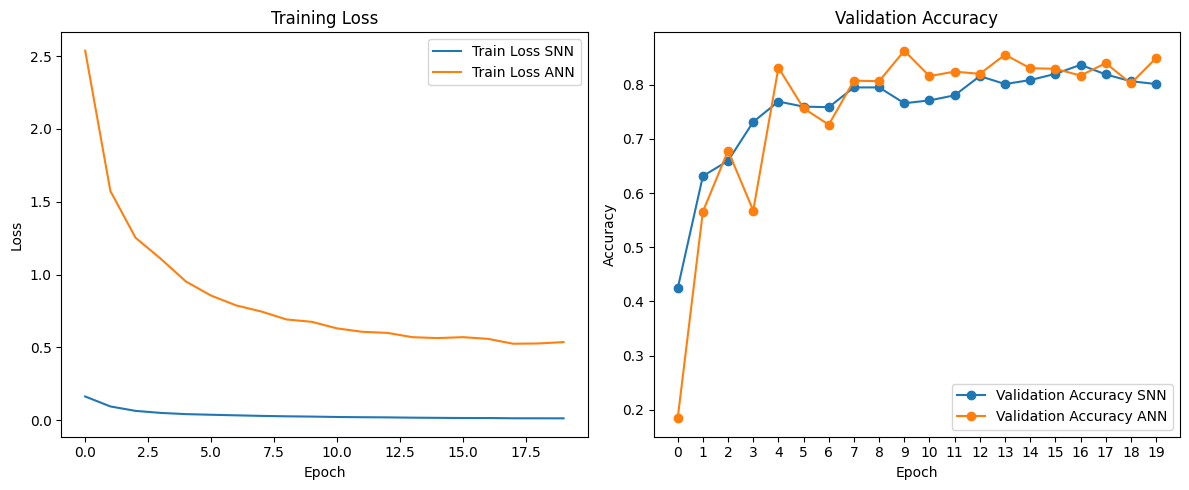

In [16]:
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_hist, label='Train Loss SNN')
plt.plot(train_loss, label='Train Loss ANN')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist, label='Validation Accuracy SNN', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy ANN', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(len(val_accuracy)))  # Установка меток для каждой эпохи
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir /kaggle/working/events.out.tfevents.1735195752.b5ef708eba70.30.0  # Замените на путь к вашей директории с логами


In [ ]:
# import time
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('/kaggle/working/')
# writer.add_scalar('Loss/train', 1, 4)
# writer.add_scalar('Loss/train', 2, 3)
# writer.add_scalar('Loss/train', 3, 2)
# writer.add_scalar('Loss/train', 4, 1)

# writer.close()